In [3]:
import numpy as np
import pandas as pd
from scipy.stats import binom, beta
import seaborn as sns
from matplotlib import pyplot as plt

np.random.seed(10)

# First Part: finding Bayes Factors

Bayes factor is a way to compare two distributions by their likelihood ratio. It summarises the strength of the evidence in favor of one hypothesis or the other

$$K = \frac{P(D|A)}{P(D|B)}$$

We will have two approaches to this problem:
1. Assuming a uniform distribution of possible biased coins
2. Assuming that 100% biased coins are fairly rare whereas 0% ones are more common

In [2]:
# For a fair coin the likelihood of getting 140 heads in 250 flips is
likes_fair = binom.pmf(140, 250, .5)  # .00836

# For a biased coin it's a bit more elaborated as we need the sum of all the likelihoods
# that are not fair, that is, everything but .5
hs = np.linspace(0, 1, 101)
p = np.ones(101) / 100  # uniform probability for each hs
probs = pd.Series(p, index=hs)
probs[.5] = 0  # everything but a fair coin
probs /= probs.sum()

likes_biased = binom.pmf(140, 250, hs)
likes_biased = np.sum(probs * likes_biased)  # 0.004

K = likes_fair / likes_biased  # 2.14
# which means that the coin is as twice as likely to be fair that to be biased

# However, one can assume that 100% biased coins are fairly rare and 0% ones are
# rather common. This way, a triangle prior can be built to account for that fact.
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
p = np.append(ramp_up, ramp_down)
probs = pd.Series(p, index=hs)
probs[.5] = 0  # Again, everything but a fair coin
probs /= probs.sum()

likes_biased = binom.pmf(140, 250, hs)
likes_biased = np.sum(probs * likes_biased)  # 0.007

K = likes_fair / likes_biased  # 1.19
# Which means that the coin is a bit more likely to be fair but not so much
# and, therefore, chances are it's biased

# Bayesian Bandits
* Draw a sample from the distribution of each bandit
* choose the argmax
* if the argmax:
    * `>.5`, choose `binom.pmf(w+1, n, hs)`
    * `binom.pmf(w, n, hs)`, otherwise
as the likelihood function
* Update prior

## Updating with beta distribution
When we say update the prior we can do a regular update or, we can save some computational resources using a beta distribution because of this relationship:
$$\mathrm{Beta}(1, 1)\cdot\mathrm{Binomial}(1, 1)\propto\mathrm{Beta}(2, 1)$$


In [3]:
hs = np.linspace(0, 1, 4)
prior = beta(1, 1).pdf(hs)

p1 = prior * binom.pmf(1, 1, hs)
p1 /= p1.sum()
p2 = beta(2, 1).pdf(hs)
p2 /= p2.sum()
assert (p1 == p2).all()
beta(1, 1).pdf(hs) * binom.pmf(1, 1, hs), beta(2, 1).pdf(hs)  # Proportional

(array([0.        , 0.33333333, 0.66666667, 1.        ]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]))

## Creating the Bandits

[(0.05, 96), (0.06, 51), (0.07, 169), (0.08, 184)]

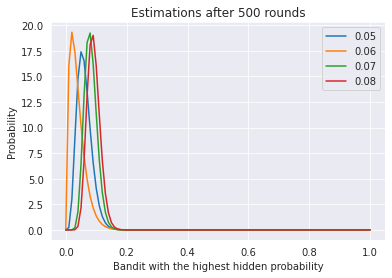

In [4]:
class Bandit:
    """Define a bandit machine."""

    def __init__(self, width=1, hidden_p=None):
        """
        Class constructor.

        Parameters:
            width: an integer that reduces the scale of the random number such that
            the hidden_p values will be closer together.
            hidden_p: override the hidden probabilities.
        """
        self.wins = 0
        self.plays = 0
        self.hs = np.linspace(0, 1, 101)
        self.dist = np.ones(101) / 100

        # We need to determine the hidden probability for the bandit to check
        # afterwards how we approach this value.

        self.hidden_p = hidden_p
        # a narrower hidden_p to see what happens
        if not hidden_p:
            shift = (50 - (100 / (width * 2))) / 100
            self.hidden_p = (np.random.random() / width) + shift

        # record the samples and the inferred probability
        self.record_tape = {
            "samples": list(),
            "idx_max": list(),
        }

    def sample_post(self):
        """Draw a sample from the posterior distribution."""
        samples_box = pd.Series(self.hs)
        sample = samples_box.sample(weights=self.dist).values[0]
        self.record_tape["samples"].append(sample)
        return sample

    def _winner_pull(self):
        """Determine a winner pull."""
        return np.random.binomial(1, self.hidden_p) == 1

    def _update_dist(self):
        """Compute the posterior probability given some sample."""
        self.plays += 1
        if self._winner_pull():
            self.wins += 1

        alpha_p = self.wins + 1
        beta_p = (self.plays - self.wins) + 1
        self.dist = beta(alpha_p, beta_p).pdf(self.hs)

        return self.dist

    def _update_dist_the_hard_way(self):
        """Compute the posterior probability given some sample."""
        self.plays += 1
        if self._winner_pull():
            self.wins += 1

        likes = binom.pmf(self.wins, self.plays, self.hs)

        self.dist *= likes
        self.dist /= self.dist.sum()
        return self.dist


    def _record_argmax_from_posterior(self):
        idx_max = pd.Series(self.dist, index=self.hs).idxmax()
        self.record_tape["idx_max"].append(idx_max)
        return idx_max

    def run(self):
        """
        If the bandit has the max sample amount among the bandits we call this method.
        to update its inferred_probability
        """
        self._update_dist()
        self._record_argmax_from_posterior()

    @property
    def last_idx(self):
        return self.record_tape["idx_max"][-1]


class Game:

    def __init__(self, bandits=3, rounds=20, width=1, hidden_ps=None):
        if hidden_ps:
            self.bandits = [
                Bandit(width=width, hidden_p=p) for p in hidden_ps
            ]
        else:
            self.bandits = [Bandit(width=width) for _ in range(bandits)]
        self.rounds = rounds
        self.max_bandit_p = max([b.hidden_p for b in self.bandits])
        self.record_tape = {
            "round_winner": list(),
            "regret": list()
        }

    def _run_round(self):
        samples = [b.sample_post() for b in self.bandits]
        max_sample = max(samples)
        max_bandit = samples.index(max_sample)
        self._update_tape(max_bandit)
        self.bandits[max_bandit].run()

    def _plot_outcomes(self):
        _, ax = plt.subplots()
        ax.set_title(f"Estimations after {self.rounds} rounds")
        ax.set_ylabel("Probability")
        ax.set_xlabel("Bandit with the highest hidden probability")
        for b in self.bandits:
            x, y = b.hs, b.dist
            sns.lineplot(x=x, y=y, label=round(b.hidden_p, 2))

    def _update_tape(self, max_bandit):
        self.record_tape["round_winner"].append(max_bandit)
        regret = self.max_bandit_p - self.bandits[max_bandit].hidden_p
        self.record_tape["regret"].append(regret)

    def run(self, plot=False):
        for _ in range(self.rounds):
            self._run_round()
        if plot:
            self._plot_outcomes()

hidden_ps = [.05, .06, .07, .08]
g = Game(rounds=500, hidden_ps=hidden_ps)
g.run(plot=True)

[(b.hidden_p, b.plays) for b in g.bandits]

In [5]:
df = pd.DataFrame(g.record_tape)
df.groupby("round_winner").regret.agg(["sum", "count"])

,sum,count
round_winner,,
0,2.88,96
1,1.02,51
2,1.69,169
3,0.00,184


As the probabilities are very close together, we notice that the distance between third and fourth is really short, the latter was played just 15 rounds more.
Also, in other runs (before applying seed to np) we noticed that the second bandit was played more times than the third one even when it had less probability.
With all, the fourth one is usually the absolute winner making the approach valid.

Let's check when the bandits are chosen.
Here we can see why the distance between the 3rd and the 4th is so narrow: in the beginning the bandit that seemed to be the winner was the third but then the fourth started to get popularity.

It's interesting that even when the fourth bandit is the one that has the most of the probability, we are still playing the first one and, if for some reason the probabilities of the bandits where dynamic, that would allow us to change our opinion about the winner, how fast? it's hard to say.

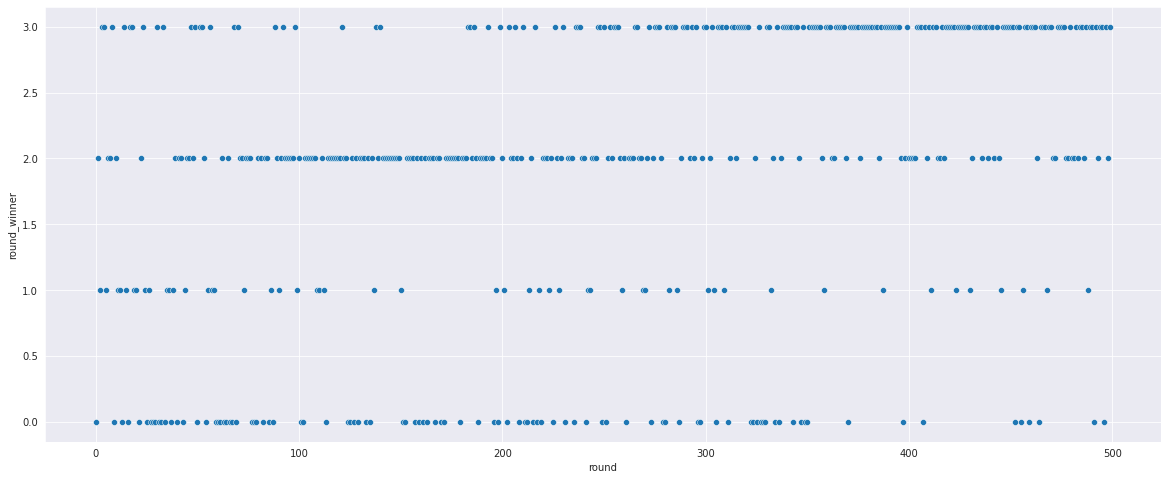

In [6]:
_, ax = plt.subplots(figsize=(20, 8))
ax.set_xlabel('round')
sns.scatterplot(x=df.index, y=df.round_winner);

In [ ]:
import numpy as np
hs = np.linspace(100, 900)
def prob_right(ability, difficulty):
        """
        Calculate the probability of the test taker to give the correct answer.

        Based on the three parameter model:
        https://en.wikipedia.org/wiki/Item_response_theory#Three_parameter_logistic_model

        Arguments:
            ability: int or numpy ndarray, the ability of the current test taker (int) or a range of abilities
            (ndarray) to calculate the likelihoods.
        """
        a = 50
        c = .25  # random guessing a four choice question
        x = a * (ability - difficulty)
        return c + ((1 - c) / (1 + np.exp(-x)))

dist = prob_right(hs, 500)

# SAT problem

**Intro:**
The ability of a test taker $\theta$ is supposed to follow a logistic function based on three parameters:
- The probability of a random guess $c$
- The difficulty of the question $b$
- The discriminatory power of the function $a$

$$\mathrm{p} = c + \frac{1-c}{1 + e^{-a (\theta-b)}}$$

So, if we know the ability of the test taker, we can come up with the probability of answering right a given question.

As usual with these problems, we don't know what is the ability of the test taker, all we can see is the result of the answers, so this becomes an **inverse problem** where we should infer that ability.

In a nutshell, this is what we are doing:
- We compute both a distribution and the outcome of a question out of a logistic function for a given ability and a given difficulty
- We update a flat distribution based on the answer outcome by doing a bayesian update. This outcome can flip the logistic function computed above which in turn will be used as the likelihood distribution for that bayesian update.
- For a range of different abilities we compute the std of the posterior after 51 questions all the same difficulty, and we plot the results
- For a few different abilities (4), we take 200 tests like above and get the mean for each of them. Then we plot the CDF that tells how that mean grows.
- We can compare them by taking the mean of the test where one person is superior to the other. In other words, this is how much the distributions overlap.

## Create the models

In [26]:
from empiricaldist import Cdf
from utils import plot_series_lowess

class Test:
    """
    Run a single test for one person.

    Attributes:
        difficulty: the initial difficulty of the questions in the test.
        hs: the range of abilities to calculate the posterior distribution.
        num_questions: the number of questions of the test.
        difficulty_delta: in the simple adaptive test, the amount we shift by the current question.
        prior: the initial distribution of abilities. In the main notebook a normal prior is used,
        but a flat one turned out a bit more performant.


    Constructor Arguments:
        ability: int, the ability of a test taker
        adaptive: str, whether the difficulty should change between tests. There are three methods to update
        the difficulty: simple, mean and sampling. Simple will increase by difficulty_delta if the answer is correct
        and decrease otherwise. Mean, will set the difficulty equal to the posterior mean. Sampling will sample a
        difficulty from an increasing ordered series of difficulties.
        discriminant: how steep should be the logistic function and therefore how good it is telling
        apart different abilities
    """

    def __init__(self, ability, adaptive=None, discriminant=100):
        self.ability = ability
        self.adaptive = adaptive
        self.discriminant = discriminant

        # Attributes
        self.difficulty = 500
        self.num_questions = 100
        self.difficulty_delta = 50
        self.hs = np.linspace(100, 900)
        self.prior = np.ones(self.hs.size) / self.hs
        self.dist = self.prob_right(self.hs)


    def prob_right(self, ability):
        """
        Calculate the probability of the test taker to give the correct answer.

        Based on the three parameter model:
        https://en.wikipedia.org/wiki/Item_response_theory#Three_parameter_logistic_model

        Arguments:
            ability: int or numpy ndarray, the ability of the current test taker (int) or a range of abilities
            (ndarray) to calculate the likelihoods.
        """
        a = 1 / self.discriminant
        c = .25  # random guessing a four choice question
        x = a * (ability - self.difficulty)
        return c + ((1 - c) / (1 + np.exp(-x)))

    def update_probability(self, response):
        """
        Perform a bayesian update on the prior distribution.

        Arguments:
            response: a bool that represents the outcome of the last question answered.
        """
        if response is True:
            likes = self.dist.copy()
        else:
            likes = 1 - self.dist.copy()

        self.prior *= likes
        self.prior /= self.prior.sum()

    def answer_question(self):
        """Flip a coin with the probability of guessing right to check the question."""
        p = self.prob_right(self.ability)
        return np.random.binomial(1, p) == 1

    def update_difficulty(self, response, i):
        """
        Shift the difficulty of the next question depending on the method chosen.

        Arguments:
            response: a bool that represents the outcome of the last question answered.
            i: int, it represents the index of the current question to be used in the sampling method.
        """
        if self.adaptive == 'simple':
            self.update_difficulty_simple(response)
            return
        elif self.adaptive == 'mean':
            self.update_difficulty_based_on_mean()
            return
        elif self.adaptive == 'sampling':
            self.update_difficulty_by_sampling(i)
            return
        elif self.adaptive:
            print(f"Warning: {self.adaptive} adaptive method not found, using fixed difficulty.")
        else:
            return

    def update_difficulty_simple(self, response):
        """
        Increase the difficulty for the next question by difficulty_delta units or decrease otherwise.

        Arguments:
            response: a bool that represents the outcome of the last question answered.
        """
        if response is True:
            self.difficulty += self.difficulty_delta
        else:
            self.difficulty -= self.difficulty_delta

    def update_difficulty_based_on_mean(self):
        """Set next question's difficulty to posterior mean."""
        self.difficulty = self.mean

    def update_difficulty_by_sampling(self, i):
        """
        Set next's question difficulty increasingly higher.

        i: int, it represents the index of the current question to pick in the range of difficulties.
        """
        difficulty = np.linspace(100, 900, self.num_questions)

        self.difficulty =  difficulty[i]

    @property
    def map(self):
        """Return the Maximum a Posteriori of the posterior distribution."""
        return self.hs[self.prior.argmax()]

    @property
    def mean(self):
        """Return the mean of the posterior distribution."""
        return (self.hs * self.prior).sum()

    @property
    def var(self):
        """Return the variance of the posterior distribution."""
        d = self.hs - self.mean
        return np.sum(d ** 2 * self.prior)

    @property
    def std(self):
        """Return the standard deviation of the posterior distribution."""
        return np.sqrt(self.var)

    def run(self):
        """Run the test for the given number of questions."""
        for i in range(self.num_questions):
            response = self.answer_question()
            self.update_probability(response)
            self.update_difficulty(response, i)  # if any
        return self


class Plot:
    """Plot side by side the cdfs and the std for a given approach of adaptive and discriminant."""

    def __init__(self, adaptive=None, discriminant=100):
        self.adaptive = adaptive
        self.discriminant = discriminant
        fig, self.ax = plt.subplots(1, 2, figsize=(16, 5))
        fig.suptitle(f'Evaluating adaptive={adaptive} and discriminant={discriminant}')

    def show_std(self):
        """
        Display a plot about how well perform a range of abilities by measuring the STD of the outcomes.

        Arguments:
            adaptive: str, whether the difficulty should change between tests. Accepts the strings that
            Test accepts.
        """
        actual_abilities = np.linspace(200, 800)
        series = pd.Series(index=actual_abilities, dtype=float, name='std')
        for ability in actual_abilities:
            k = Test(ability=ability, adaptive=self.adaptive, discriminant=self.discriminant).run()
            series[ability] = k.std

        plot_series_lowess(series, 'C1', ax=self.ax[1])
        self.ax[1].set_xlabel('Actual ability')
        self.ax[1].set_ylabel('Standard deviation of posterior')
        self.ax[1].set_title(f'Standard deviation for a range of abilities.')

    def sample_posterior(self, ability, iterations=200):
        """
        Run several test for a given ability.

        Arguments:
            ability: int, it represents the ability of the test taker.
            iterations: int, the number of tests the function should run.
            adaptive: str, whether the difficulty should change between tests. Accepts the strings that
            Test() accepts.
        """
        return np.array([
            Test(
                ability=ability, adaptive=self.adaptive, discriminant=self.discriminant
            ).run().mean for _ in range(iterations)
        ])

    def show_cdfs(self):
        """
        Show comparative cumulative distribution functions for a set of abilities.

        Arguments:
            adaptive: str, whether the difficulty should change between tests. Accepts the strings that
            Test accepts.
        """
        abilities = (500, 600, 700, 800)
        colors = ('C1', 'C2', 'C3', 'C4')
        s1, s2, s3, s4 = [self.sample_posterior(ability) for ability in abilities]
        print(
            f"Experiment-{self.adaptive}-{self.discriminant}: ",
            np.mean(s2 > s1), np.mean(s3 > s2), np.mean(s4 > s3))
        for n, sample in enumerate((s1, s2, s3, s4)):
            cdf = Cdf.from_seq(sample)
            cdf.plot(label=f'ability={abilities[n]}', color=colors[n], ax=self.ax[0])

        self.ax[0].set_xlabel('Test score')
        self.ax[0].set_ylabel('CDF')
        self.ax[0].set_title(f'Sampling distribution of test scores.')
        handles, labels = self.ax[0].get_legend_handles_labels()
        self.ax[0].legend(handles, labels)

    def run(self):
        self.show_cdfs()
        self.show_std()


## Outcomes
### No adaptation outcomes

Experiment-None-50:  1.0 1.0 0.675
Experiment-None-100:  0.99 0.995 0.92
Experiment-None-150:  0.95 0.965 0.93


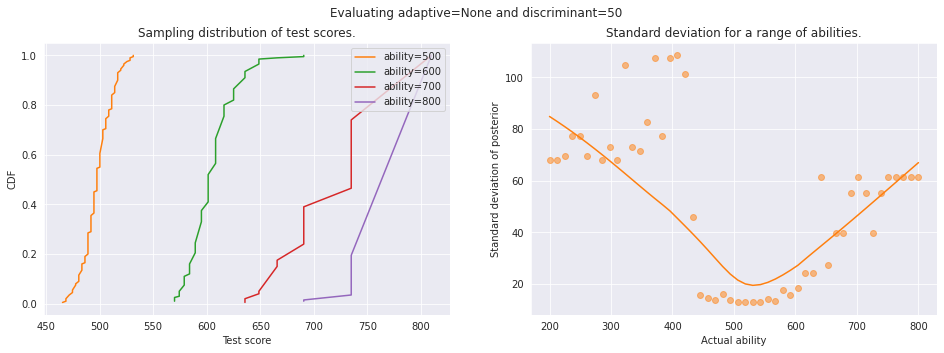

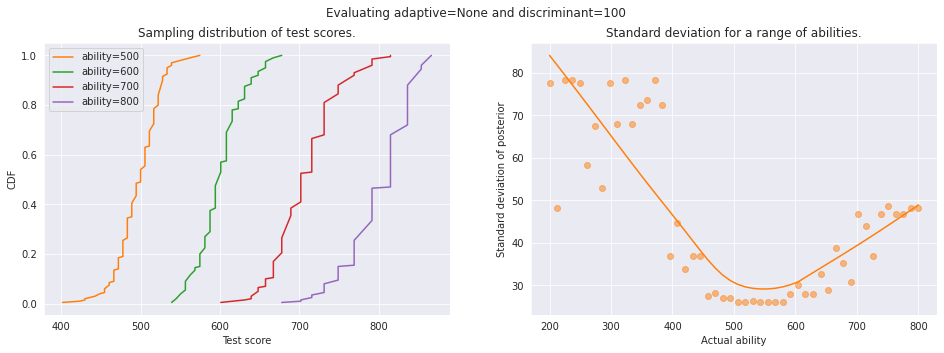

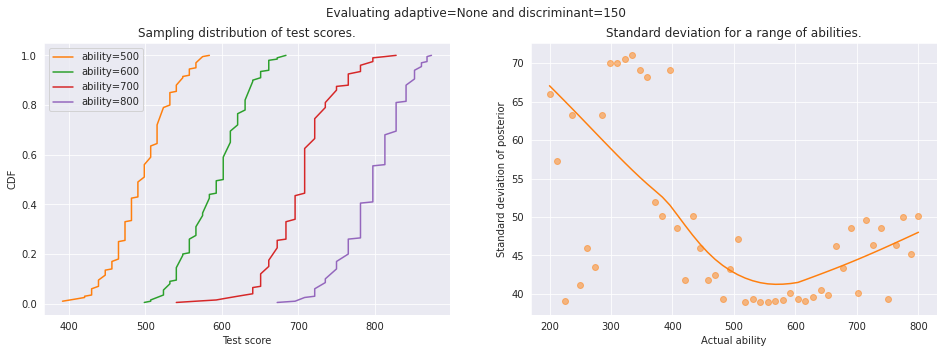

In [15]:
Plot(discriminant=50).run()
Plot(discriminant=100).run()
Plot(discriminant=150).run()

### Simple adaptation outcomes

Experiment-simple-50:  0.79 0.79 0.755
Experiment-simple-100:  0.695 0.66 0.715
Experiment-simple-150:  0.69 0.665 0.68


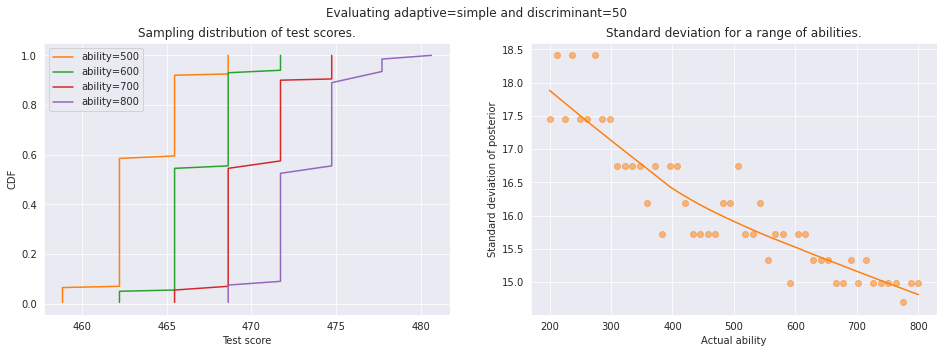

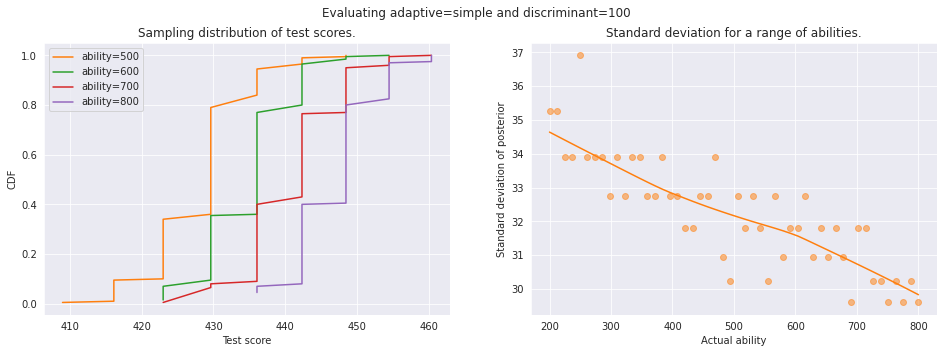

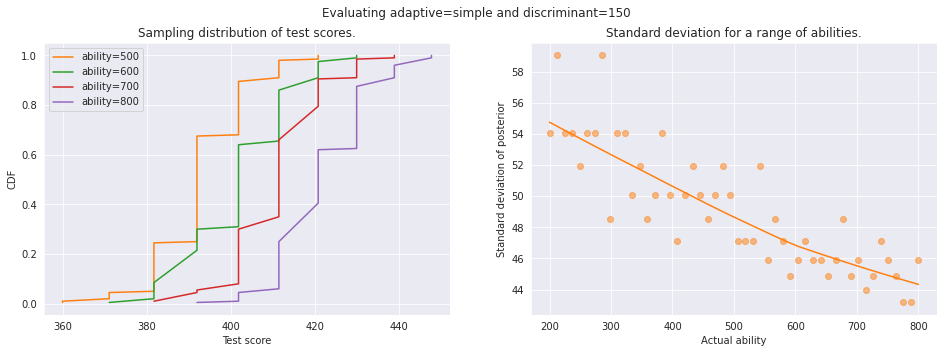

In [16]:
Plot(adaptive='simple', discriminant=50).run()
Plot(adaptive='simple', discriminant=100).run()
Plot(adaptive='simple', discriminant=150).run()

### Sampling adaptation outcomes

Experiment-sampling-50:  0.965 0.985 0.975
Experiment-sampling-100:  0.945 0.95 0.93
Experiment-sampling-150:  0.92 0.915 0.935


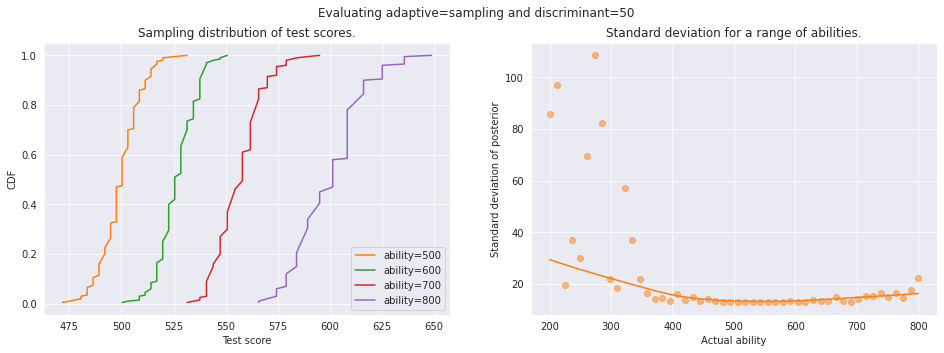

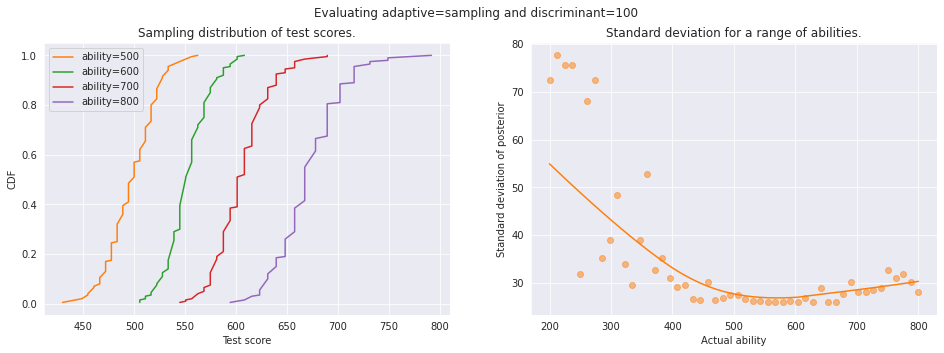

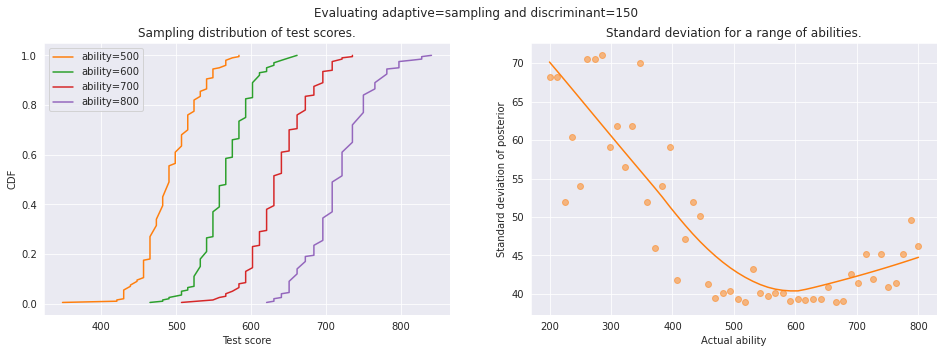

In [17]:
Plot(adaptive='sampling', discriminant=50).run()
Plot(adaptive='sampling', discriminant=100).run()
Plot(adaptive='sampling', discriminant=150).run()

### Mean adaptation outcomes

Experiment-mean-50:  1.0 1.0 0.99
Experiment-mean-100:  0.99 0.99 0.945
Experiment-mean-150:  0.93 0.935 0.925


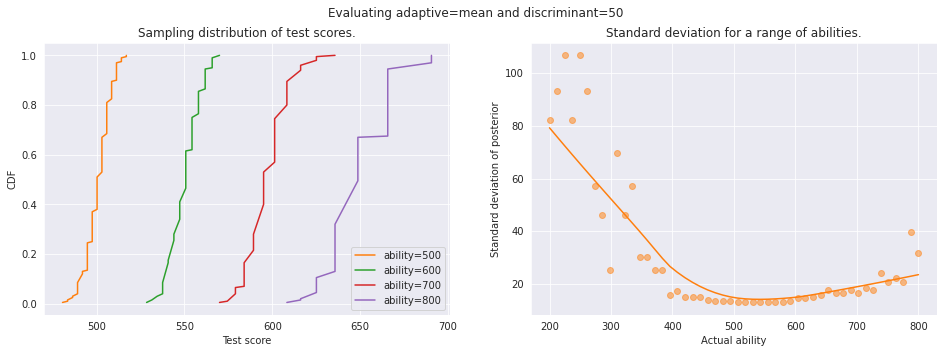

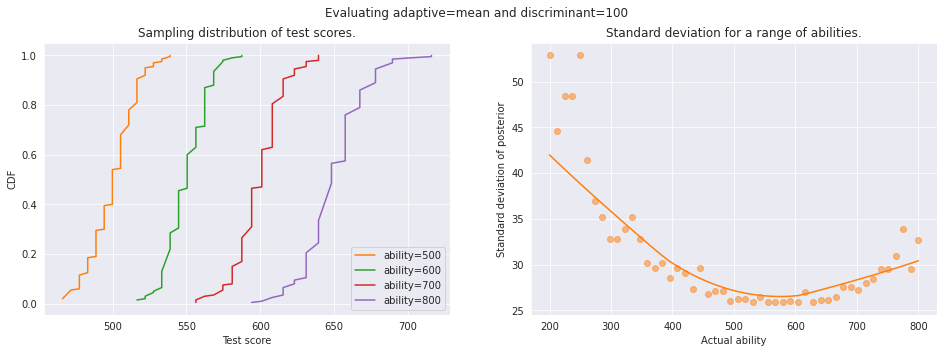

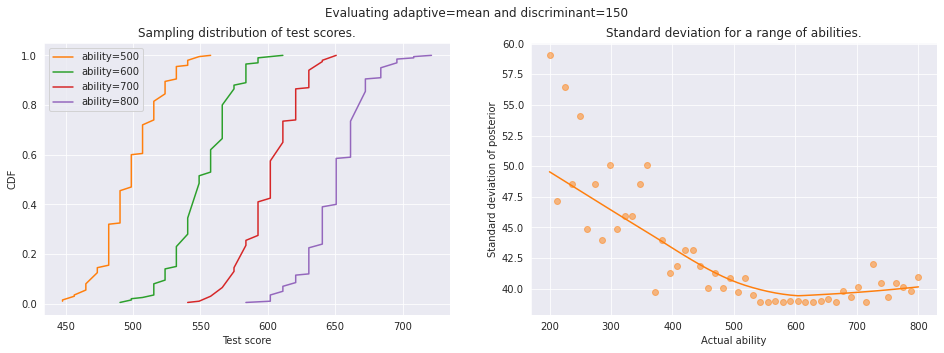

In [27]:
Plot(adaptive='mean', discriminant=50).run()
Plot(adaptive='mean', discriminant=100).run()
Plot(adaptive='mean', discriminant=150).run()

## Conclusion
We can reach the max accuracy when we choose the discriminant=50 and the adaptive method mean. Still, the discriminatory power comes at the expense of the precision, as to get a low std one has to select a discriminant=100